# Image Classification
## Project Overview


*   Problem Statement: Given an image of t-shirt, classify it into one of the 
following two categories:
  1.   plain(solid) t-shirt or
  2.   typography t-shirt(contains text)

*   This is a binary classification problem
*   The same concepts can be applied to any other binary classification problem
*   With some minor modifications, the same code and process can be expanded to multi-category or even multi-label problems(We wont be covering them here)
*   We will be leveraging such techniques as Deep learning, which is a subfield within ML, Convolutional Neural Networks (CNNs) and Transfer learning 
*   We will also explore some regularization topics such as Image augumentation and Dropout
*   We will be using [Tensorflow](https://www.tensorflow.org) library for majority of DL heavy lifting 
*   [Google colab](https://colab.research.google.com/) will be used to run this notebook as it has provision to run the training and inference on GPUs free of cost
*   At a high level we will follow this structure in the code:
    1. Importing libraries
    2. Importing and examining data
    3. Training the model
        * Will explore different DL architectures, parameters and hyperparameters
    4. Evaluating the model
    5. Examining the metrics and plots
 
 Let's begin..!!


# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/colab_projects/image-classification/

[Errno 2] No such file or directory: 'drive/MyDrive/colab_projects/image-classification/'
/content/drive/MyDrive/colab_projects/image-classification


In [ ]:
import os
import tensorflow as tf
import tensorflow.keras.models as models

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
from tensorflow.keras import metrics

In [ ]:
import pandas as pd

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Input Data

### Paths

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data_path = "/content/drive/MyDrive/colab_projects/image-classification/input/images/train"

In [ ]:
validation_data_path = "/content/drive/MyDrive/colab_projects/image-classification/input/images/valid"

### Train and validation image data generator

We also implement image augumentation for training images. This will help reduce overfitting

####Folder structure

Labels are automatically inferred from the folder names

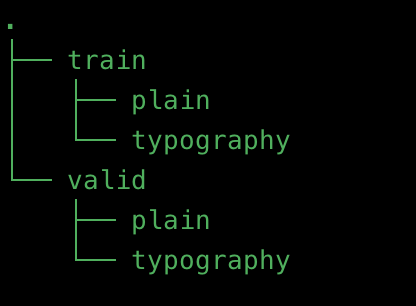

In [ ]:
## Initializing Training ImageDataGenerator class with various augumentation params
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
## defining batch size and the image shape and specifying the source path
## the labels are automaotically built from the folder name in the directory

train_generator = train_datagen.flow_from_directory(train_data_path, 
                                                    batch_size =32,
                                                    class_mode = 'binary',
                                                    target_size = (150,150),
                                                    seed=99)

Found 607 images belonging to 2 classes.


In [ ]:
# train_generator.filepaths

In [ ]:
## initialzing validation imagedatagenerator class with only rescale param. Others are kept at default
validation_datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
validation_generator = validation_datagen.flow_from_directory(validation_data_path,shuffle=False,
                                                              batch_size = 32,
                                                              class_mode = 'binary',
                                                              target_size = (150, 150))

Found 152 images belonging to 2 classes.


In [ ]:
training_data_df = pd.DataFrame(data={"file":train_generator.filepaths,
                                      "labels": train_generator.labels})

In [ ]:
training_data_df.sample()

,file,labels
223,/content/drive/MyDrive/colab_projects/image-cl...,0


### Visualizing training data

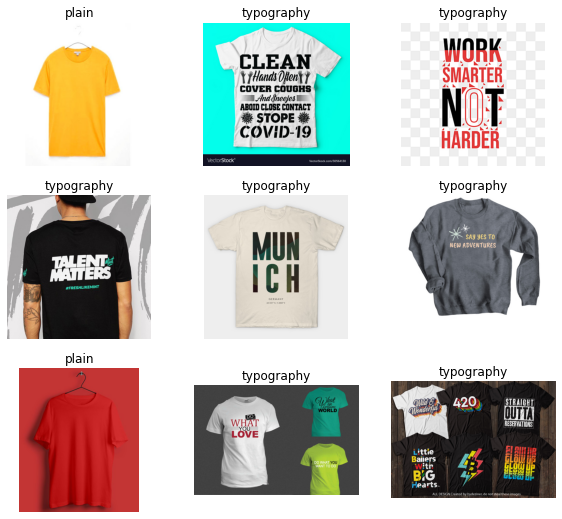

In [ ]:
## visualizing some training data
sample_training_data = training_data_df.sample(10)
sample_training_data.reset_index(drop=True, inplace=True)
label_mapping = {0:"plain", 1:"typography"}

plt.figure(figsize=(10,9))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(mpimg.imread(sample_training_data.iloc[i]['file']))
  plt.title(label_mapping[sample_training_data.iloc[i]['labels']])
  plt.axis("off")

# Model Training

### Deep Learning and Convolutions


1.   Deep learning because we dont need to handcraft features unlike other machine learning techniques
2.   Deep learning for Computer Vision is further improved by use of convolutions
3. Models like [VGG-16](https://arxiv.org/pdf/1409.1556.pdf), [MobileNet](https://arxiv.org/pdf/1704.04861.pdf), 
[Inception](https://arxiv.org/pdf/1409.4842.pdf) have become increasingly popular in solving wide variety of problems, achieving state of the art results

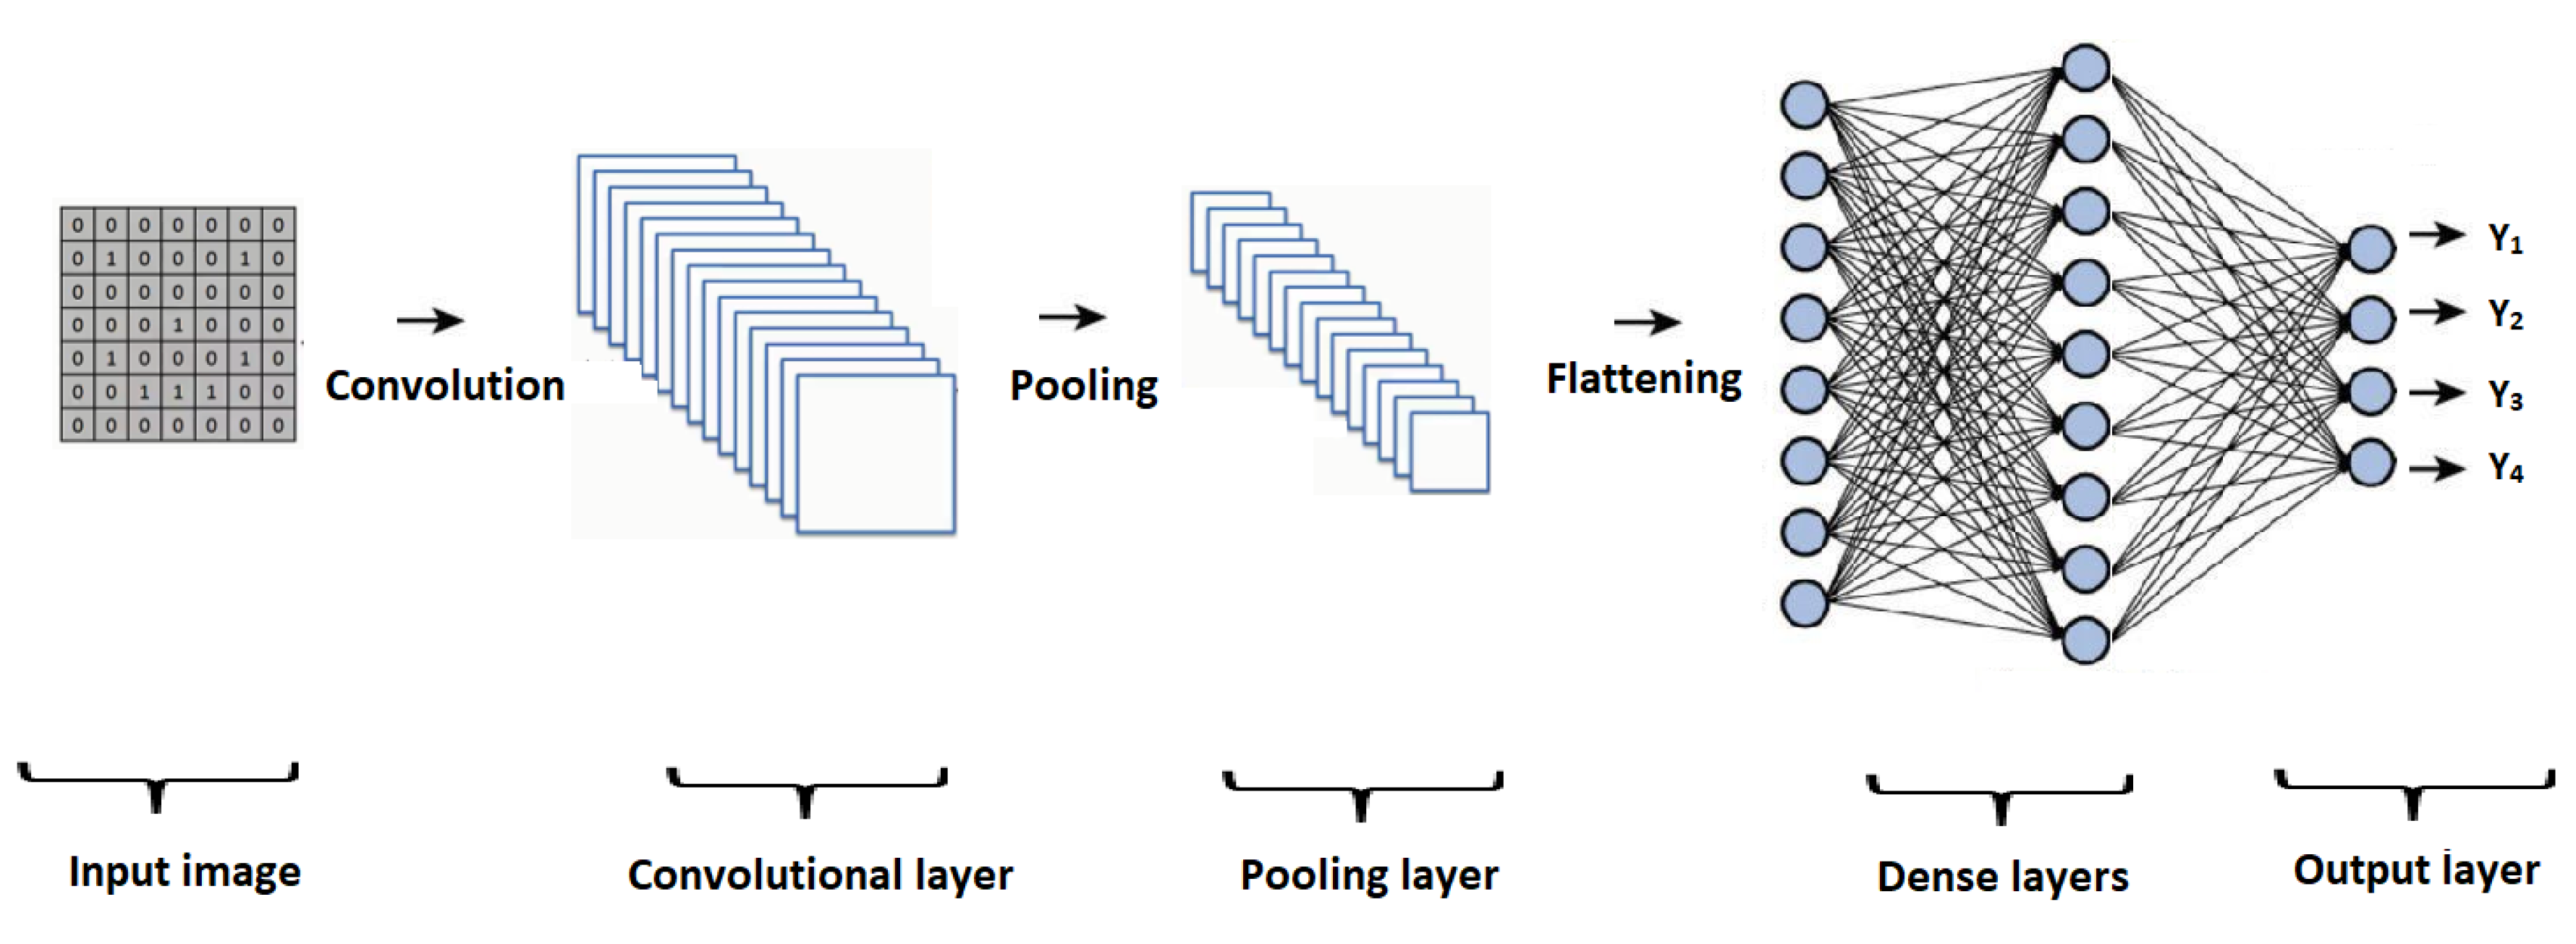

## Download model weights, initialzing and training
### Hyperparmaters to tune:

---


1.  Learning Rate
2.  Dropout fraction
3.  `#` fully connected layers & `#`nodes in each layer

### Transfer Learning
* Resnet
* Inception
* Training only the newly added layers

In [ ]:
def get_pre_trained_model_inception():

  from tensorflow.keras.applications.inception_v3 import InceptionV3

  try:
    # downloading the model weights
    # !wget --no-check-certificate \
    #   https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    #   -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
      
    # weights_filepath = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

    ## initializing the pretrained trained model to suit to out needs 
    ## Transfer Learning
    model = InceptionV3(include_top=False,
                            input_shape=(150, 150, 3),
                            weights='imagenet'
                            )
  
    #loading custom weights
    # model.load_weights(weights_filepath)
  except:
    print("Initializing pre-trained model failed !!")

  # freezing the pretrained model weights so that they wont be updated during back propagation
  for layer in model.layers:
    layer.trainable = False

  last_layer = model.get_layer("mixed7")
  last_output = last_layer.output

  return model, last_output

In [ ]:
def get_pre_trained_model_resnet():
  from tensorflow.keras.applications.resnet50 import ResNet50

  model = ResNet50(include_top=False, weights = 'imagenet', input_shape=(150,150,3))
  
  for layer in model.layers:
    layer.trainable = False
    # model.summary()
  output = model.layers[-1].output

  return model, output

In [ ]:
def get_optimizer(optimizer_name="adam", lr=0.0001):

    # preparing optimizer
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == "rmsprop":
        optimizer = RMSprop(learning_rate=lr)

    return optimizer

In [ ]:
def define_model(model="inception", learning_rate = 0.000001):
  
  """
  :return: compiled pretrained model
  """

  # change this as per the experiment
  if model == 'inception':
    model, last_output = get_pre_trained_model_inception() 
  elif model == 'resnet':
    model, last_output = get_pre_trained_model_resnet()

  ## Adding layers on top of the pretrained model

  ## flattening the convoultion output
  x = layers.Flatten()(last_output)
  # adding fully connected layer
  x = layers.Dense(1024, activation='relu')(x)
  # Dropout layer for regularization
  x = layers.Dropout(0.2)(x)
  # sigmoid layer for final prediction
  x = layers.Dense(1, activation='sigmoid')(x)
  model = models.Model(model.input, x)

  optimizer = get_optimizer(lr=learning_rate)

  # model compilation
  model.compile(optimizer=optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
  
  return model

In [ ]:
def get_callbacks():
  """
  returns a list of callback functions
  """
  ## earlystopping to prevent overfitting
  from tensorflow.keras.callbacks import EarlyStopping
  es_callback = EarlyStopping(monitor='val_loss', patience=5)

  return [es_callback]



In [ ]:
def fit_model(model='inception',lr=0.000001):

  model = define_model(model=model,learning_rate=lr)

  callbacks = get_callbacks()

  history = model.fit(train_generator,
                       validation_data = validation_generator,
                       epochs = 2,
                       steps_per_epoch =None,
                       validation_steps = None,
                       verbose = 1,
                      callbacks= callbacks)
  
  return history, model

In [ ]:
history, model = fit_model()

Epoch 1/2
 5/19 [======>.......................] - ETA: 18s - loss: 0.7347 - accuracy: 0.4500

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 38s 1s/step - loss: 0.7024 - accuracy: 0.5222 - val_loss: 0.6706 - val_accuracy: 0.6250
Epoch 2/2
19/19 [==============================] - 17s 921ms/step - loss: 0.6363 - accuracy: 0.6705 - val_loss: 0.6272 - val_accuracy: 0.7303


In [ ]:
## saving the model to a file
model.save("/content/drive/MyDrive/colab_projects/image-classification/output/models/inceptionV3_clf_model.h5", save_format="h5")

In [ ]:
#loading the model
model = tf.keras.models.load_model("/content/drive/MyDrive/colab_projects/image-classification/output/models/inceptionV3_clf_model.h5")

### Training plots

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, metrics=['loss', 'binary_accuracy']):
    
    num_metrics = len(metrics)
    
    plt.figure(figsize=(10,9))
    for i,metric in enumerate(metrics):
        epochs = range(1, (len(history[metric])+1))
        plt.subplot(num_metrics, 1,(i+1))
        plt.plot(epochs, history[metric], label = 'training_'+metric)
        plt.plot(epochs, history['val_'+metric], label = 'validation_'+metric)
        plt.title("Training and validation "+metric)
        plt.ylabel(metric)
        plt.xlabel('epochs')
        plt.legend()
        plt.show()
        #plt.savefig("/content/output/train_metrics.pdf")
        
    plt.close()

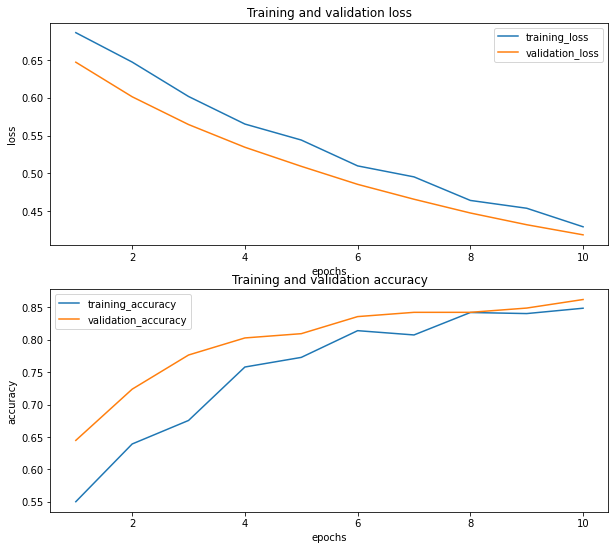

In [ ]:
plot_metrics(history.history, metrics = ['loss', 'accuracy'])

In [ ]:
# plt.savefig("output/plt1.jpeg")

#Model Testing:
1. What is testing?
2. Why model testing is important?
3. How do we do it?
4. Which metrics are important? 

    ##### a. Precision
    ##### b. Recall
    ##### c. f1-score
    ##### d. Accuracy
    ##### e. ROC-AUC

### Estimating test accuracy

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

In [ ]:
import numpy as np

In [ ]:
import seaborn as sns

In [ ]:
test_data_path = "/content/drive/MyDrive/colab_projects/image-classification/input/images/test"

In [ ]:
#loading the model
model = tf.keras.models.load_model("/content/drive/MyDrive/colab_projects/image-classification/output/models/inceptionV3_clf_model.h5")

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(test_data_path,shuffle=False,
                                                              batch_size = 32,
                                                              class_mode = 'binary',
                                                              target_size = (150, 150))

Found 100 images belonging to 2 classes.


In [ ]:
model_evaluation = model.evaluate(test_generator)

4/4 [==============================] - 4s 340ms/step - loss: 0.6321 - accuracy: 0.7200


In [ ]:
print(dict(zip(model.metrics_names, model_evaluation)))

{'loss': 0.6321064233779907, 'accuracy': 0.7200000286102295}


### Predictions

In [ ]:
predictions = model.predict(test_generator)

In [ ]:
predictions[:10]

array([[0.36856234],
       [0.45017225],
       [0.40573493],
       [0.46506974],
       [0.45074317],
       [0.5388152 ],
       [0.31432018],
       [0.41660354],
       [0.49628657],
       [0.60023814]], dtype=float32)

In [ ]:
predictions = np.where(predictions>0.5,1,0)

In [ ]:
predictions.reshape((100,))

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1])

In [ ]:
cm = confusion_matrix(test_generator.labels, predictions)

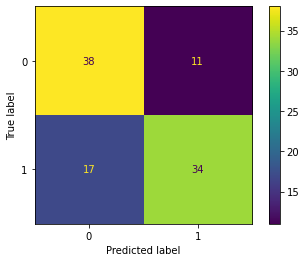

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_generator.labels, predictions)

In [ ]:
cr = classification_report(test_generator.labels, predictions, labels=[1,0])

In [ ]:
print(cr)

              precision    recall  f1-score   support

           1       0.76      0.67      0.71        51
           0       0.69      0.78      0.73        49

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100



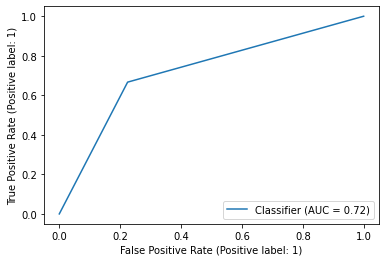

In [ ]:
RocCurveDisplay.from_predictions(test_generator.labels, predictions)

### Analyzing incorrect predictions

In [ ]:
pred_vs_actuals_df = pd.DataFrame(data = {"actual_label":test_generator.labels,
                                          "pred_label":predictions.reshape(-1),
                                          "file":test_generator.filepaths})

In [ ]:
pred_error_df = pred_vs_actuals_df[pred_vs_actuals_df.pred_label!=pred_vs_actuals_df.actual_label]
pred_error_df = pred_error_df.sample(5)
pred_error_df.reset_index(drop=False, inplace = True)

In [ ]:
pred_error_df.sample()

,index,actual_label,pred_label,file
1,89,1,0,/content/drive/MyDrive/colab_projects/image-cl...


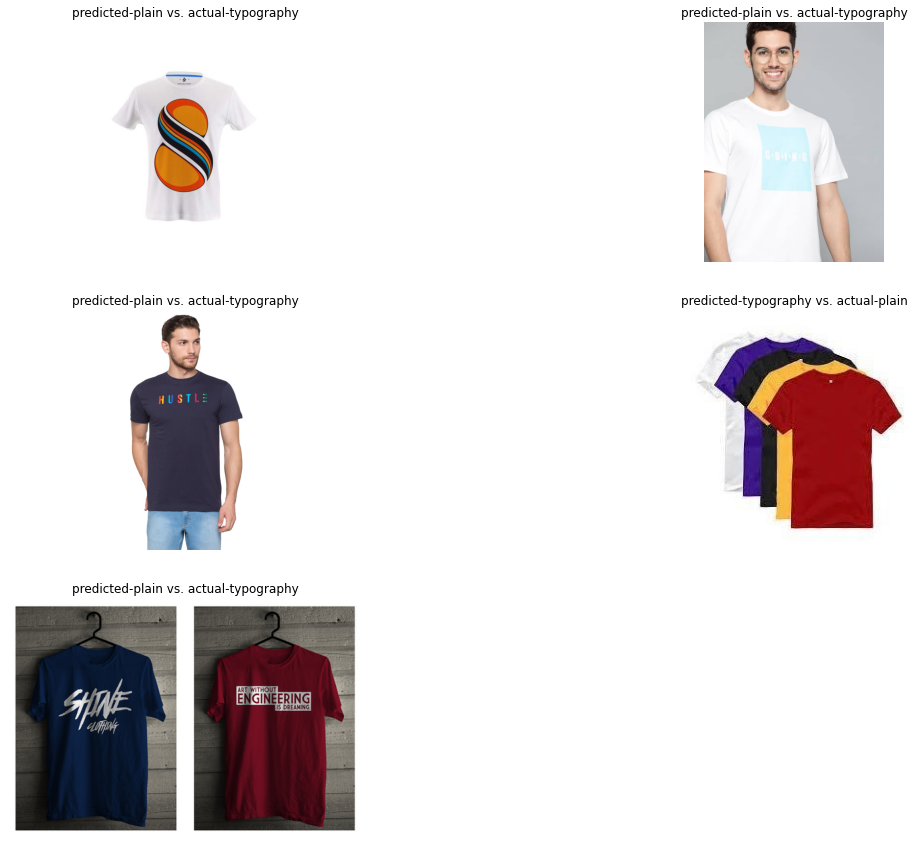

In [ ]:
## visualizing incorrect predictions

label_mapping = {0:"plain", 1:"typography"}

plt.figure(figsize=(20,15))


for i in range(pred_error_df.shape[0]):
  plt.subplot(np.ceil(pred_error_df.shape[0]/2), 2, i + 1)
  plt.imshow(mpimg.imread(pred_error_df.iloc[i]['file']))
  plt.title("predicted-{} vs. actual-{}".format(label_mapping[pred_error_df.iloc[i]['pred_label']], label_mapping[pred_error_df.iloc[i]['actual_label']] ))
  plt.axis("off")

# Hyperparameter tuning

In [ ]:
param_grid={'learning_rate':[0.000001, 0.00001,0.001]}

In [ ]:
for param in param_grid.keys():
  print("Tuning {}".format(param))
  if param == 'learning_rate':
    for lr in param_grid[param]:
      print("\n")
      print("\tTrying with {0}={1}".format(param,lr))
      fit_model(lr=lr)

Tuning learning_rate


	Trying with learning_rate=1e-06
Epoch 1/2
 1/19 [>.............................] - ETA: 1:28 - loss: 0.7313 - accuracy: 0.6250

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 24s 1s/step - loss: 0.6551 - accuracy: 0.6425 - val_loss: 0.6016 - val_accuracy: 0.7500
Epoch 2/2
19/19 [==============================] - 17s 919ms/step - loss: 0.6150 - accuracy: 0.6771 - val_loss: 0.5636 - val_accuracy: 0.8026


	Trying with learning_rate=1e-05
Epoch 1/2
19/19 [==============================] - 24s 1s/step - loss: 0.5535 - accuracy: 0.7496 - val_loss: 0.3972 - val_accuracy: 0.8487
Epoch 2/2
19/19 [==============================] - 17s 926ms/step - loss: 0.3794 - accuracy: 0.8534 - val_loss: 0.3160 - val_accuracy: 0.8882


	Trying with learning_rate=0.001
Epoch 1/2
19/19 [==============================] - 24s 1s/step - loss: 1.8354 - accuracy: 0.7430 - val_loss: 1.1772 - val_accuracy: 0.7500
Epoch 2/2
19/19 [==============================] - 17s 905ms/step - loss: 0.2845 - accuracy: 0.9044 - val_loss: 0.3853 - val_accuracy: 0.9408
